## Prologue

Run these cells prior to running any cell below, in order for the script and models to function in a proper way.

In [1]:
# Install libraries

import os
import sys
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from IPython.display import display, HTML

# Ignore warnings 
pd.options.mode.chained_assignment = None

# Set figure size
plt.rcParams['figure.figsize'] = [25, 10]

In [2]:
# Create universally (i.e. across various operating systems) recognized paths

notebook_path = os.path.abspath('Resolution 3650.ipynb')          # Jupyter notebook path
TCDF_path = os.path.join(os.path.dirname(notebook_path), 'TCDF')       # TCDF folder path
TCDFdata_path = os.path.join(TCDF_path, 'data')                        # TCDF/data folder path
EBT_path = os.path.join(os.path.dirname(notebook_path), 'EBT Data')    # EBT folder path
DefaultCod_path = os.path.join(EBT_path, 'Modified Default Cod')       # EBT/Modified Default Cod folder path
Cod_path = os.path.join(DefaultCod_path, 'Modified Default.out')       # EBT/Modified Default Cod/Modified Default.out file path

In [3]:
# Install conda- and pip packages in the current Jupyter kernel

!conda install -c anaconda tensorflow --y
!pip3 install torch torchvision torchaudio
!{sys.executable} -m pip install torchvision

Solving environment: ...working... done

# All requested packages already installed.



In [4]:
# Load clean data from EBT tool into DataFrame
file_path = os.path.join(TCDFdata_path, 'EBT_dataset.csv')
ebt = pd.read_csv(file_path, delimiter = ',', header = 0)

# Define labels
labels = ['Time (year)',
          'Rs', 'Rj', 'Ra',                               # Shared resources biomass
          'Sj', 'Sa', 'Sb',                               # Sprat stages biomass
          'Cj', 'Ca', 'Cb',                               # Cod stages biomass
          'Fc']
biomass_labels = ['Rs', 'Rj', 'Ra',                       # Shared resources biomass
                  'Sj', 'Sa', 'Sb',                       # Sprat stages biomass
                  'Cj', 'Ca', 'Cb',                       # Cod stages biomass
                  'Fc']

ebt = ebt[labels]

In [5]:
# Define function for visualisation of scaled data 

def plot_data(data, years): 
    """This function plots selected data within given timeframe [years] for the triptrophic community. 
    Provided data should be a DataFrame with at least columns [Cj, Ca, Cb, Sj, Sa, Sb, Rj, Rs, Ra].
    The years argument is given as a list with two numbers between 0 and 100."""
    
    # Select data to be visualized
    cod = data[['Cj', 'Ca', 'Cb']]
    sprat = data[['Sj', 'Sa', 'Sb']]
    resource = data[['Rj', 'Rs', 'Ra']]
    data['Time'] = np.linspace(years[0], years[1], len(data))
    time = data['Time']

    # Set subplot figure defaults
    fig, [cod_plt, sprat_plt, resource_plt] = plt.subplots(3, 1, sharex = True)
    fig.subplots_adjust(hspace = 0)
    fig.suptitle('Cod-sprat-resource dynamics {start}-{stop} years (scaled)'.format(start=years[0],stop=years[1]))

    # Set labels for shared x-axis and individual y-axes
    cod_plt.set(ylabel = 'Cod biomass')
    sprat_plt.set(ylabel = 'Sprat biomass')
    resource_plt.set(ylabel = 'Resource biomass')
    plt.xlabel('Time (years)')

    # Visualize data
    cod_plt.plot(time, cod)
    sprat_plt.plot(time, sprat)
    resource_plt.plot(time, resource)

    # Add legends
    cod_plt.legend(['Cj', 'Ca', 'Cb'], loc = 'center left')
    sprat_plt.legend(['Sj', 'Sa', 'Sb'], loc = 'center left')
    resource_plt.legend(['Rj', 'Rs', 'Ra'], loc = 'center left')

    # Remove Time column
    data.drop(['Time'], axis = 1, inplace = True)

In [6]:
# Define function that preprocesses (i.e. scale min-max) and select data from desired timeframe 

def select_data(data, start, stop, preprocessor='min-max'):        
    """This function preprocesses selected data.
    Three processing methods can be used (min-max, standard, power) - min-max default.
    Selection of data timeframe is specified with the [start] and [stop] arguments."""

    # Select information of datapoints
    selected_data = data[(data['Time (year)'] >= start) & (data['Time (year)'] <= stop)]

    # Normalize data
    # Min-max normalization
    if preprocessor == 'min-max':
        scaler = MinMaxScaler()
    # Power transformer normalization
    elif preprocessor == 'power':
        scaler = PowerTransformer()  
    # Standard normalization
    elif preprocessor == 'standard':
        scaler = StandardScaler()
    
    scaled = scaler.fit_transform(selected_data[biomass_labels])
    
    # Write scaled data to DataFrame
    processed_data = pd.DataFrame(scaled, columns = biomass_labels)

    # Check the scaled DataFrame
    display(processed_data.head(-10))
    # Plot scaled data 
    plot_data(processed_data, [start,stop])
    
    return processed_data

In [7]:
# Define function to plot the model's loss or accuracy (i.e. performance) after running 

def plot_performance(losses_or_accuracy):
    """This function plots the losses for each trained variable for the TCDF model.
    Takes a dictionary with either losses or accuracy for each variable as input"""
    
    # Preallocate plots in subplots
    fig, axs = plt.subplots(3, 3, sharex = True)
    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Performance measure')

    # Iterate over each key in dictionary
    keys = list(losses_or_accuracy.keys())
    
    # Plot every variable in different subplot
    axs[0, 0].plot(np.arange(len(losses_or_accuracy[keys[0]])), losses_or_accuracy[keys[0]])
    axs[0, 0].set_title('Performance Rs')
    axs[0, 1].plot(np.arange(len(losses_or_accuracy[keys[1]])), losses_or_accuracy[keys[1]])
    axs[0, 1].set_title('Performance Rj')
    axs[0, 2].plot(np.arange(len(losses_or_accuracy[keys[2]])), losses_or_accuracy[keys[2]])
    axs[0, 2].set_title('Performance Ra')
    axs[1, 0].plot(np.arange(len(losses_or_accuracy[keys[3]])), losses_or_accuracy[keys[3]])
    axs[1, 0].set_title('Performance Sj')
    axs[1, 1].plot(np.arange(len(losses_or_accuracy[keys[4]])), losses_or_accuracy[keys[4]])
    axs[1, 1].set_title('Performance Sa')
    axs[1, 2].plot(np.arange(len(losses_or_accuracy[keys[5]])), losses_or_accuracy[keys[5]])
    axs[1, 2].set_title('Performance Sb')
    axs[2, 0].plot(np.arange(len(losses_or_accuracy[keys[6]])), losses_or_accuracy[keys[6]])
    axs[2, 0].set_title('Performance Cj')
    axs[2, 1].plot(np.arange(len(losses_or_accuracy[keys[7]])), losses_or_accuracy[keys[7]])
    axs[2, 1].set_title('Performance Ca')
    axs[2, 2].plot(np.arange(len(losses_or_accuracy[keys[8]])), losses_or_accuracy[keys[8]])
    axs[2, 2].set_title('Performance Cb')


In [8]:
# Define function for adding white noise

def noise(signal, snr):
    """This function adds white Gaussian noise to a signal.
    Noise is added to existing signal and created by a desired signal-to-noise ratio (SNR).
    Function returns the original signal with added noise by the given SNR."""

    # Set mean noise to 0, indicative for white noise
    mean_noise = 0
    sample = len(signal)
    
    # Calculate averages to determine signal power
    average_mean = np.mean(signal)
    average_snr = (10 * np.log10(average_mean)) - snr    
    average_noise = 10 ** (average_snr / 10)

    # Generate noisy signal
    noise_variation = np.random.normal(mean_noise, np.sqrt(average_noise), sample)
    
    # Add noise to the original signal
    noise_signal = signal + noise_variation
    
    return noise_signal

In [9]:
# Define function for creating noisy dataset

def noisy_data(snr):
    """This function creates a noisy dataset from an existing deterministic dataset_3650.
    Noise is added to the dataset with a previous specified function noise().
    Function returns the original dataset with added noise."""
    
    # Create dataframe for noisy data
    noisy_ebt = pd.DataFrame(ebt)

    # Add noise for relevant columns
    for col in ebt[biomass_labels]:
        noisy_ebt[col] = noise(ebt[col], snr)

    # Visualise unscaled and scaled data 
    plot_data(noisy_ebt, [0,100])
    
    # Write the final dataset to DataFrame named noisy_ebt
    noisy_ebt['Time (year)'] = ebt['Time (year)']
    
    return noisy_ebt

In [10]:
# Define function for creating dataset with different resolutions

def resolution(dataset, res=1):
    """This function creates a new dataset of a user specified resolution. 
    Default resolution is the given resolution of inputdataset_3650. 
    Resolution should be any positive integer between 0 and length of inputdataset_3650.
    This function will then skip any number of rows of given resolution to create a new lower resolution dataset_3650."""
    
    # Compress dataset to specified resolution
    res_dataset = dataset.iloc[::res, :]
    res_dataset.reset_index(drop = True, inplace = True)

    return res_dataset

In [11]:
# Define needed directory
directory = TCDF_path

# Check current working directory
current_directory = os.getcwd()

# Change working directory to perform TCDF
if current_directory != directory:
    os.chdir(TCDF_path)

# Check new current working directory
os.getcwd()

'C:\\Users\\10528504\\Documents\\GitHub\\thesis\\TCDF'

This part shows the functionality of TCDF.

See the corresponding paper for more detail: ["Causal Discovery with Attention-Based Convolutional Neural Networks"](https://www.mdpi.com/2504-4990/1/1/19).

# Start of Experiments

## Min Max Scaling

### Signal to Noise ratio 1:0

### Resolution 3650

In [12]:
# Set new resolution with 3650 datapoints
ebt = resolution(ebt, 100)

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

,Rs,Rj,Ra,Sj,Sa,Sb,Cj,Ca,Cb,Fc
0,1.000000e+00,0.018102,0.644498,0.442333,0.000000,0.458831,0.879566,0.202771,1.000000,0.000000
1,9.998158e-01,0.018248,0.645534,0.442679,0.000021,0.458896,0.879360,0.202283,0.992058,0.006897
2,9.981274e-01,0.018994,0.648723,0.445305,0.000212,0.459392,0.878837,0.201242,0.969452,0.013793
3,9.931672e-01,0.020498,0.652655,0.452063,0.000797,0.460848,0.878579,0.200906,0.934580,0.020690
4,9.838885e-01,0.022493,0.654771,0.463175,0.001902,0.463804,0.879339,0.203152,0.890567,0.027586
...,...,...,...,...,...,...,...,...,...,...
168,3.275245e-05,0.942243,0.999995,0.022719,0.955788,0.069776,0.016958,0.000005,0.000073,0.000000
169,1.855795e-05,0.950241,0.999995,0.019593,0.961704,0.060514,0.014518,0.000004,0.000071,0.000000
170,9.125002e-06,0.957388,0.999996,0.016804,0.967028,0.052161,0.012363,0.000004,0.000069,0.000000
171,3.427936e-06,0.963759,0.999996,0.014318,0.971808,0.044645,0.010462,0.000004,0.000067,0.000000


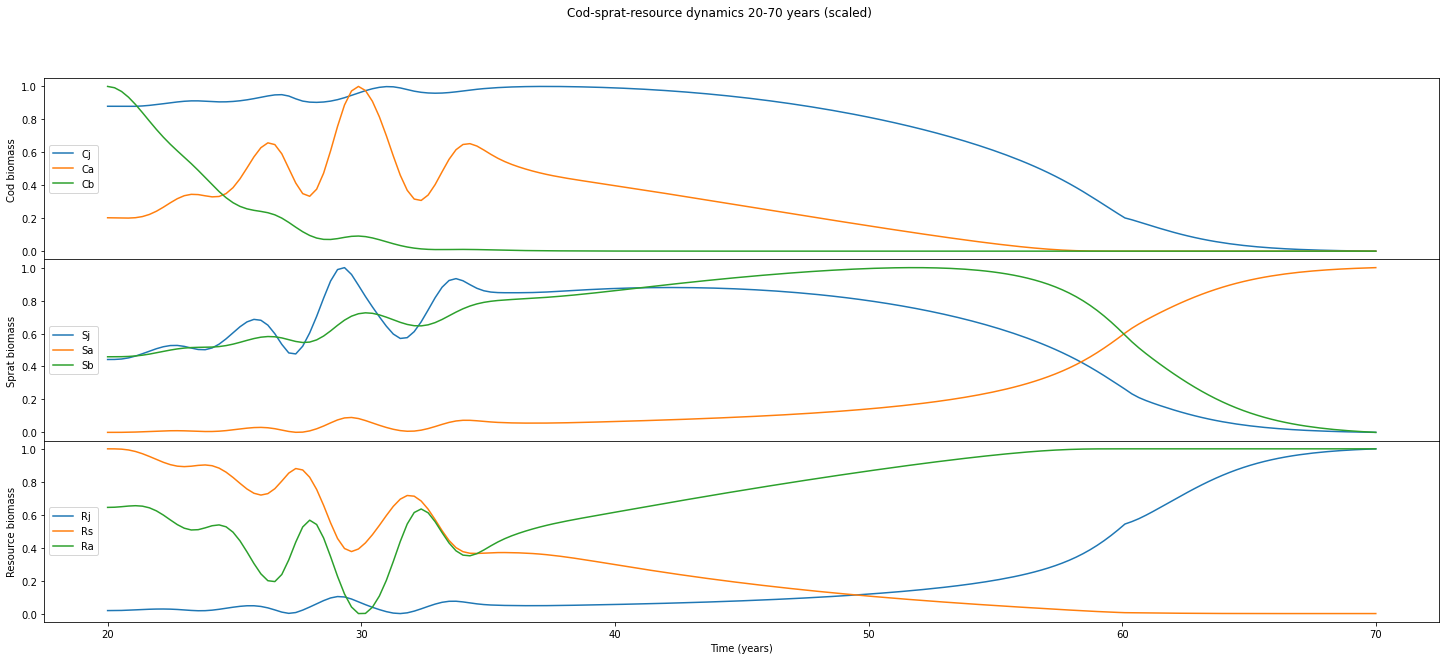

In [13]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.098873
Epoch    28: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.004900
Epoch: 500 [50%] 	Loss: 0.001752
Epoch: 750 [75%] 	Loss: 0.000418
Epoch   834: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1000 [100%] 	Loss: 0.000331
Potential causes:  [2, 3, 6]
Validated causes:  [2, 3]

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.103277
Epoch    88: reducing learning 

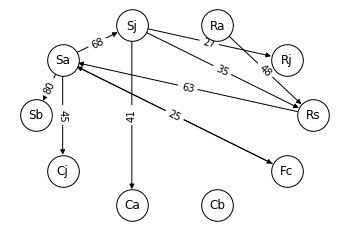

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.138341
Epoch   205: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000814
Epoch: 500 [50%] 	Loss: 0.000613
Epoch: 750 [75%] 	Loss: 0.000437
Epoch: 1000 [100%] 	Loss: 0.000308

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.059107
Epoch    24: reducing learning rate of group 0 to 1.0000e-02.
Epoch    58: reducing learning rate of group 0 to 1.0000e-03.
Epoch    69: reducing learning rate of group 0 to 1.0000e-04.
Epoch    80: reducing learning rate of group 0 to

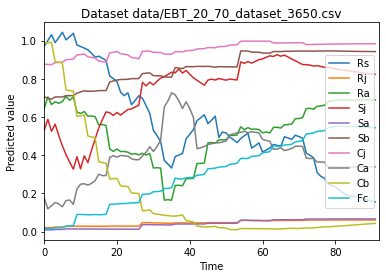

<Figure size 432x288 with 0 Axes>

In [15]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=2371, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.110530
Epoch   150: reducing learning rate of group 0 to 1.0000e-02.
Epoch   161: reducing learning rate of group 0 to 1.0000e-03.
Epoch   172: reducing learning rate of group 0 to 1.0000e-04.
Epoch   183: reducing learning rate of group 0 to 1.0000e-05.
Epoch   194: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [25%] 	Loss: 0.003242
Epoch: 500 [50%] 	Loss: 0.003227
INFO: Early stopping
Potential causes:  [8, 2, 1, 0, 4]
Validated causes:  []

 Analysis started for target:  R

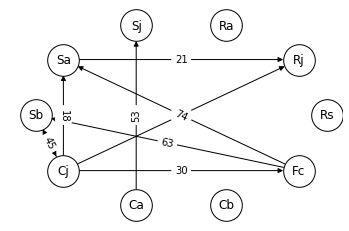

<Figure size 432x288 with 0 Axes>

In [16]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=2371, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.200589
Epoch   120: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000821
Epoch: 500 [50%] 	Loss: 0.000646
Epoch: 750 [75%] 	Loss: 0.000389
Epoch: 1000 [100%] 	Loss: 0.000213

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.020470
Epoch    19: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000330
Epoch: 500 [50%] 	Loss: 0.000228
Epoch: 750 [75%] 	Loss: 0.000146
Epoch: 1000 [100%] 	Loss: 0.000060

 Analysis started for target:  Ra
INFO

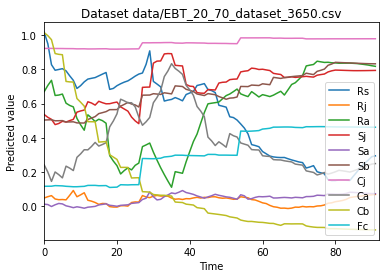

<Figure size 432x288 with 0 Axes>

In [17]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=3, early_stopping=True, epochs=1000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1084, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.391346
Epoch    93: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000983
Epoch: 500 [50%] 	Loss: 0.000655
Epoch: 750 [75%] 	Loss: 0.000321
Epoch   777: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1000 [100%] 	Loss: 0.000296
Potential causes:  [8, 1, 9, 0]
Validated causes:  []

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.344429
Epoch   152: reducing learning r

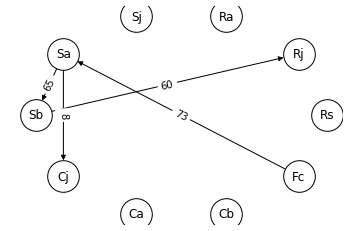

<Figure size 432x288 with 0 Axes>

In [18]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=3, early_stopping=True, epochs=1000, hidden_layers=3, kernel_size=3, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=1048, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.255574
Epoch   173: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [25%] 	Loss: 0.000561
Epoch: 500 [50%] 	Loss: 0.000465
Epoch: 750 [75%] 	Loss: 0.000334
Epoch: 1000 [100%] 	Loss: 0.000216

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.005821
Epoch    14: reducing learning rate of group 0 to 1.0000e-02.
Epoch    25: reducing learning rate of group 0 to 1.0000e-03.
Epoch    36: reducing learning rate of group 0 to 1.0000e-04.
Epoch    47: reducing learning rate of group 0 to

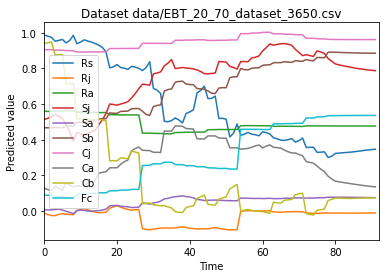

<Figure size 432x288 with 0 Axes>

In [19]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

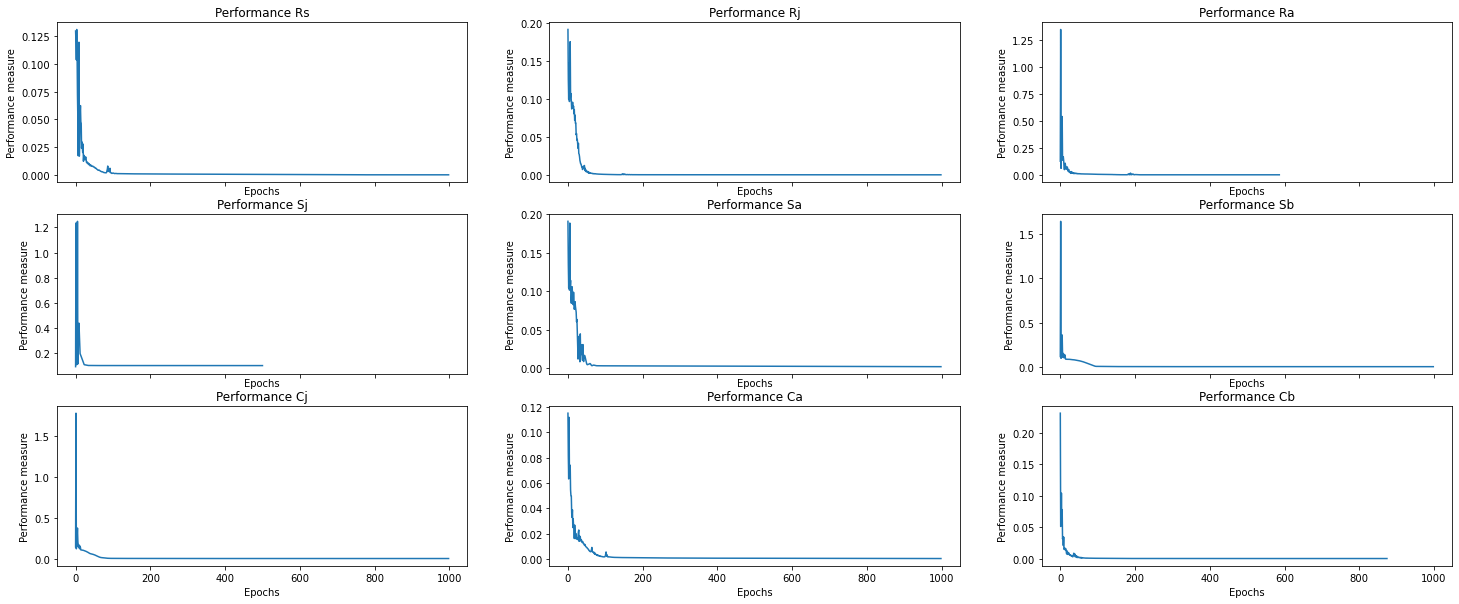

In [20]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

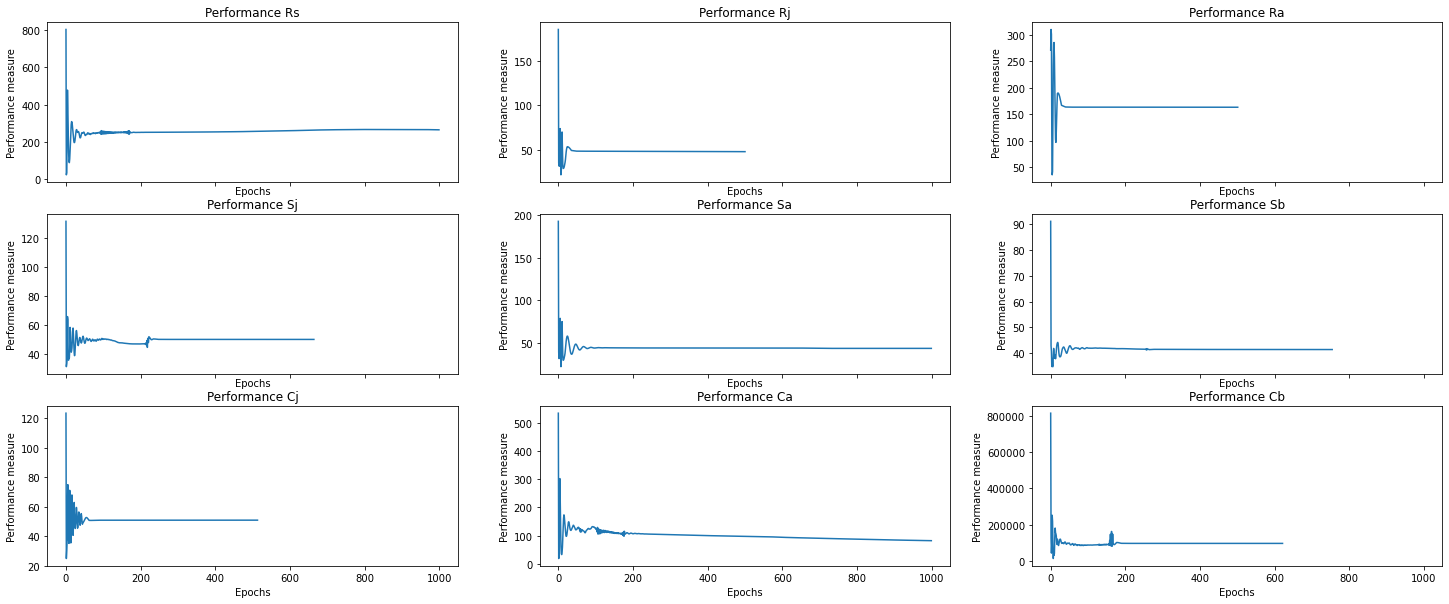

In [21]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

Arguments: Namespace(cuda=False, data=None, dilation_coefficient=4, early_stopping=True, epochs=2000, ground_truth={'data/EBT_20_70_dataset_3650.csv': 'data/EBT_demo_groundtruth.csv'}, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, significance=0.9)

 Dataset:  EBT_20_70_dataset_3650.csv

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.110150
Epoch   183: reducing learning rate of group 0 to 1.0000e-02.
Epoch   194: reducing learning rate of group 0 to 1.0000e-03.
Epoch   215: reducing learning rate of group 0 to 1.0000e-04.
Epoch   226: reducing learning rate of group 0 to 1.0000e-05.
Epoch   237: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 250 [12%] 	Loss: 0.000585
Epoch: 500 [25%] 	Loss: 0.000572
INFO: Early stopping
Potential causes:  [2, 9, 8]
Validated causes:  []

 Analysis started for target:  Rj
INFO

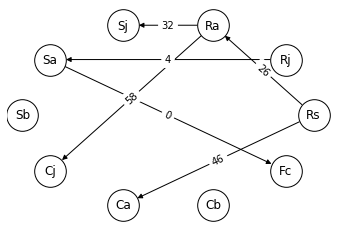

<Figure size 432x288 with 0 Axes>

In [22]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

Arguments: Namespace(cuda=False, data=['data/EBT_20_70_dataset_3650.csv'], dilation_coefficient=4, early_stopping=True, epochs=2000, hidden_layers=2, kernel_size=4, learning_rate=0.1, log_interval=250, lr_scheduler=True, optimizer='Adam', plot=True, seed=5467, train_test_split=0.5)

 Analysis started for target:  Rs
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.195709
Epoch    40: reducing learning rate of group 0 to 1.0000e-02.
Epoch: 250 [12%] 	Loss: 0.001476
Epoch: 500 [25%] 	Loss: 0.000719
Epoch: 750 [38%] 	Loss: 0.000479
Epoch: 1000 [50%] 	Loss: 0.000346
Epoch: 1250 [62%] 	Loss: 0.000280
Epoch  1410: reducing learning rate of group 0 to 1.0000e-03.
Epoch: 1500 [75%] 	Loss: 0.000240
Epoch: 1750 [88%] 	Loss: 0.000232
Epoch: 2000 [100%] 	Loss: 0.000222

 Analysis started for target:  Rj
INFO: Initializing learning rate scheduler
INFO: Initializing early stopping
Epoch:  1 [0%] 	Loss: 0.023237
Epoch    15: reducing learning rate o

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_20 = select_data(ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_70_100 = select_data(ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_0.1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70)

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, '1_10_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot training losses
plot_performance(alllosses)


## Power Transformation Scaling

### Signal to Noise ratio 1:0
### Resolution 3650

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
ebt_0_20 = select_data(ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
ebt_70_100 = select_data(ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_0.1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'power')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'power_1_10_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/power_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/power_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

## Standardized Scaling

### Signal to Noise ratio 1:0
### Resolution 3650

### TCDF with EBT total dynamics

This data represents the tritrophic biomasses including the total dynamics (shift change). The system first is at its equilibrium and remains stable for ~20 years, fishing pressure is introduced and a new equilibrium is to be found (at 70 years it is stable again). Data is split into two 'total dynamics', 0 - 100 years and 20 - 70 years respectively.

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
ebt_20_70 = select_data(ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
ebt_0_100 = select_data(ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

### TCDF with EBT equilibrium dynamics

This data represents the tritrophic biomasses before the introduced fishing pressure on cod. The system first finds it equilibrium and remains stable for ~20 years. Therefore, no relations should be found by the machine learning model.

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
ebt_0_20 = select_data(ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
ebt_70_100 = select_data(ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### TCDF with EBT transient dynamics

This data represents the tritrophic biomasses during the introduced fishing pressure on cod. At 20 years Fc increases and is put to a halt on 40 years. Therefore I split the transient dynamics into two separate transient phases: 20-40 years (fishing pressure increases linearly) and 40-70 years (searching for a new equilibrium).

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
ebt_20_60 = select_data(ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 1000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
ebt_60_70 = select_data(ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

## TCDF: Noisy Data

Same exact models are run with noisy data.

### Adding white noise (Additive White Gaussian Noise)

Training the model with additive noise might be helpful in avoiding overfitting of the model. Data in this section is augmented by adding noise with additive white Gaussian noise. Three different datasets are provided - SNR 1:0.1, 1:1, 1:10. Each noisy dataset is analysed with optimized (hyper)parameters for the particular dataset to increase performance and accuracy.

### Signal to Noise ratio 1:0.1

In [ ]:
# Create new dataset with snr 1:0.1
noisy_ebt = noisy_data(10)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_0.1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:1

In [ ]:
# Create new dataset with snr 1:1
noisy_ebt = noisy_data(1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 60 and 70 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_1_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_1_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

### Signal to Noise ratio 1:10

In [ ]:
# Create new dataset with snr 1:10
noisy_ebt = noisy_data(0.1)

#### 20 - 70 years

In [ ]:
# Select data between 20 and 70 years
noisy_ebt_20_70 = select_data(noisy_ebt, 20, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_20_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_70.to_csv(EBTScaled_path, index = False)

#### TCDF 20-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 5678


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2371


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2371 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1084


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1048 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-70 years: second run (decreased hidden layers by 1, incremented dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 5467


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 5467 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 9238


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 9238 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 157


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 157 --plot --train_test_split 0.5

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 0 - 100 years

In [ ]:
# Select data between 0 and 100 years
noisy_ebt_0_100 = select_data(noisy_ebt, 0, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_0_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_100.to_csv(EBTScaled_path, index = False)

#### TCDF 0-100 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 15787

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 15787 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 74326

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 74326 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### TCDF 0-100 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1111

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1111 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18040

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18040 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected total dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 86547

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 86547 --plot --train_test_split 0.4

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(accuracy)

#### 0 - 20 years

In [ ]:
# Select data between 0 and 20 years
noisy_ebt_0_20 = select_data(noisy_ebt, 0, 20, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_0_20_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_0_20.to_csv(EBTScaled_path, index = False)

#### TCDF 0 - 20 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37519

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37519 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 49741

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 49741 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 37786

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 37786 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 0-20 years: second run (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 94139


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 94139 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 18147


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 18147 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 69089


In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_0_20_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 69089 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 70 - 100 years

In [ ]:
# Select data between 70 and 100 years
noisy_ebt_70_100 = select_data(noisy_ebt, 70, 100, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_70_100_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_70_100.to_csv(EBTScaled_path, index = False)

#### TCDF 70-100: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34321

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34321 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 85672

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 85672 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 63109

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 63109 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Set figure size 
plt.rcParams['figure.figsize'] = [25, 10]

# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 70-100: second run  (increased hidden layers by 1, decreased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 1238

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 1238 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 53988

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 53988 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 92422

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_70_100_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 92422 --plot --train_test_split 0.8

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 20 - 60 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_20_60 = select_data(noisy_ebt, 20, 60, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_20_60_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_20_60.to_csv(EBTScaled_path, index = False)

#### TCDF 20-60 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 24310

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 24310 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 77139

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 77139 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 45184

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 45184 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 20-60 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 78025

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 78025 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 53391

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 53391 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 34061

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_20_60_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 34061 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### 60 - 70 years

In [ ]:
# Select data between 20 and 60 years
noisy_ebt_60_70 = select_data(noisy_ebt, 60, 70, 'standard')

# Create file path for new file
EBTScaled_path = os.path.join(TCDFdata_path, 'standard_1_10_noisy_EBT_60_70_dataset_3650.csv')

# Write clean dataframe demo_ebt to a new .csv file
noisy_ebt_60_70.to_csv(EBTScaled_path, index = False)

#### TCDF 60-70 years: first run (in triplicate)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 33520

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 33520 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 3 --kernel_size 3 --seed 66848

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 3 --epochs 2000 --log_interval 250 --dilation_coefficient 3 --kernel_size 3 --seed 66848 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

#### TCDF 60-70 years: second run  (decreased hidden layers by 1, increased dilation coefficient and kernel size by 1)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 2369

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 2369 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 21312

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 21312 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
%matplotlib inline
# Plot accuracy (MASE values)
plot_performance(accuracy)

In [ ]:
%matplotlib inline

# Run TCDF with the selected equilibrium dataset of EBT data

%run -i "runTCDF.py"  --ground_truth data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv=data/EBT_demo_groundtruth.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --significance 0.9 --dilation_coefficient 4 --kernel_size 4 --seed 8023

In [ ]:
# Run TCDF for predictive accuracy

%run -i "evaluate_predictions_TCDF.py" --data data/standard_1_10_noisy_EBT_60_70_dataset_3650.csv --learning_rate 0.1 --hidden_layers 2 --epochs 2000 --log_interval 250 --dilation_coefficient 4 --kernel_size 4 --seed 8023 --plot --train_test_split 0.7

In [ ]:
%matplotlib inline
# Plot training losses
plot_performance(alllosses)

In [ ]:
# Plot accuracy (MASE values)
plot_performance(accuracy)